In [1]:
# Imports
import os
import shutil
import random
import numpy as np
import skimage.segmentation
import skimage.io
import albumentations as A
import torch
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
from matplotlib.widgets import Button
from tqdm import tqdm
from utils import get_loaders
from UNET.dataset import BBBC_039_data
from UNET.model import UNET, ResUNET
from UNET.utils import load_checkpoint, split_and_process_img
# from torchsummary import summary


In [2]:
# create config dictionary
config = {
    'source_dir': '../dataset/BBBC_039',
    'dest_dir': '../dataset/BBBC_039_formatted',
    'min_nucleus_size': 25,
    'boundary_size': 2,
}

def read_file_lines(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    return lines

train_files = read_file_lines(os.path.join(config['source_dir'], 'metadata', 'training.txt'))
test_files = read_file_lines(os.path.join(config['source_dir'], 'metadata', 'test.txt'))
val_files = read_file_lines(os.path.join(config['source_dir'], 'metadata', 'validation.txt'))

In [3]:
# rand_int = 48
# rand_file_name = test_files[rand_int].strip('\n')
# test_img = skimage.io.imread(os.path.join(config['dest_dir'], 'test/images', rand_file_name))
# test_annot = skimage.io.imread(os.path.join(config['dest_dir'], 'test/boundary_labels', rand_file_name))
# # test_img = np.stack((test_img, test_annot[..., 2]), axis=0)
# test_annot = 1.0 - test_annot[..., 2].astype(np.float32) / 255.0
# print(np.amax(test_annot[..., 2]))
# overlapped_base_truth = np.stack((test_img,) * 3, axis=-1)
# overlapped_base_truth[..., 2] = test_img * test_annot
# overlapped_base_truth[..., 0] = test_img * test_annot
# print(overlapped_base_truth.shape)
# plt.figure(figsize=(10, 10))
# plt.imshow(overlapped_base_truth)
# plt.show()

In [4]:
# rand_int = 1
# rand_file_name = test_files[rand_int].strip('\n')
# test_img = skimage.io.imread(os.path.join(config['dest_dir'], 'test/images', rand_file_name))
# test_annot = skimage.io.imread(os.path.join(config['dest_dir'], 'test/boundary_labels', rand_file_name))
# # thicken the boundary
# # test_annot = skimage.morphology.binary_dilation(test_annot)
# 
# test_contour = 1.0 - test_annot[..., 2].astype(np.float32) / 255.0
# 
# overlapped_base_truth = np.stack((test_img,) * 3, axis=-1)
# overlapped_base_truth[..., 2] = test_img * test_contour
# overlapped_base_truth[..., 0] = test_img * test_contour
# 
# # normalize image to [0, 1]
# test_img = test_img / 255.0
# print(np.amax(test_img))
# 
# img_list = [
#     np.stack((test_img,) * 3, axis=-1),
#     overlapped_base_truth
# ]
# SIZE = 9
# plt.figure(figsize=(len(img_list)*SIZE, SIZE))
# 
# for idx, img in enumerate(img_list):
#     plt.subplot(1, len(img_list), idx + 1)
#     plt.imshow(img_list[idx])
#     
# plt.show()

In [3]:
def load_model(model_architecture, checkpoint, device='cuda'):
    match model_architecture:
        case 'UNET':
            model = UNET(in_channels=1, out_channels=1).to(device)
            transform = A.Compose(
                [
                    A.Normalize(
                        mean=[0.0],
                        std=[1.0],
                        max_pixel_value=255.0,
                    ),
                ]
            )
        case 'ResUNET':
            encoder = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
            model = ResUNET(encoder, 1, True).to(device)
            transform = A.Compose(
                [
                    A.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]
                    ),
                ]
            )
        case _:
            raise NotImplementedError(f'Unknown model architecture: {model_architecture}')
    load_checkpoint(checkpoint, model)
    return model, transform

In [5]:
def show_prediction(img, true_annot, model, model_architecture, size=10, device='cuda', transform=None):
    match model_architecture:
        case 'UNET':
            test_img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device).float()
            model.eval()
            with torch.no_grad():
                preds = torch.sigmoid(model(test_img))
                preds = (preds > 0.5).float()
                preds = preds.squeeze(0).squeeze(0).squeeze(0).cpu().numpy()
            model.train()
            contour = true_annot[..., 2]
            
            if transform is not None:
                transformed = transform(image=img, mask=contour)
                img = transformed['image']
                contour = transformed['mask']
                
            negative_contour = 1.0 - contour.astype(np.float32) / 255.0
    
            overlapped_base_truth = np.stack((img,) * 3, axis=-1)
            overlapped_base_truth[..., 2] = img * negative_contour
            overlapped_base_truth[..., 0] = img * negative_contour
            
            negative_preds = 1.0 - preds
            
            overlapped_preds = np.stack((img,) * 3, axis=-1)
            overlapped_preds[..., 2] = img * negative_preds
            overlapped_preds[..., 0] = img * negative_preds
            
            img_list = [
                np.stack((img,) * 3, axis=-1),
                overlapped_base_truth,
                contour,
                overlapped_preds,
                preds
            ]
        
        case 'ResUNET':
            print(f'img shape: {img.shape}')
            preds = split_and_process_img(img, 256, 256, model=model, transform=transform, device=device)
            contour = true_annot[..., 2]
            
            # from grayscale to rgb
            contour = np.repeat(contour[:, :, np.newaxis], 3, axis=2)
            img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
            preds = np.repeat(preds[:, :, np.newaxis], 3, axis=2)
            
            if transform is not None:
                transformed = transform(image=img, mask=contour)
                # img = transformed['image']
                contour = transformed['mask']
                
            img_copy = np.copy(img)
            negative_contour = 1.0 - contour.astype(np.float32) / 255.0
            overlapped_base_truth = img_copy
            overlapped_base_truth[..., 2] = img_copy[..., 2] * negative_contour[..., 2]
            overlapped_base_truth[..., 0] = img_copy[..., 0] * negative_contour[..., 0]
            
            
            img_copy = np.copy(img)
            negative_preds = 1.0 - preds
            overlapped_preds = img_copy
            overlapped_preds[..., 1] = img_copy[..., 1] * negative_preds[..., 1]
            overlapped_preds[..., 2] = img_copy[..., 2] * negative_preds[..., 2]
            
            img_list = [
                img,
                # overlapped_base_truth,
                contour,
                # overlapped_preds,
                # preds
            ]
        
        case _:
            raise NotImplementedError(f'Unknown model architecture: {model_architecture}')
    
    
    title_list = [
        'Original Image',
        # 'Original Image with Ground Truth',
        'Ground Truth',
        # 'Original Image with Predictions',
        # 'Predictions'
    ]
    plt.figure(figsize=(len(img_list)*size, size))
    
    for idx, img in enumerate(img_list):
        plt.subplot(1, len(img_list), idx + 1)
        plt.title(title_list[idx])
        plt.imshow(img_list[idx])
    plt.show()

Using cache found in /Users/tudorpitic/.cache/torch/hub/pytorch_vision_v0.10.0


=> Loading checkpoint
img shape: (520, 696)


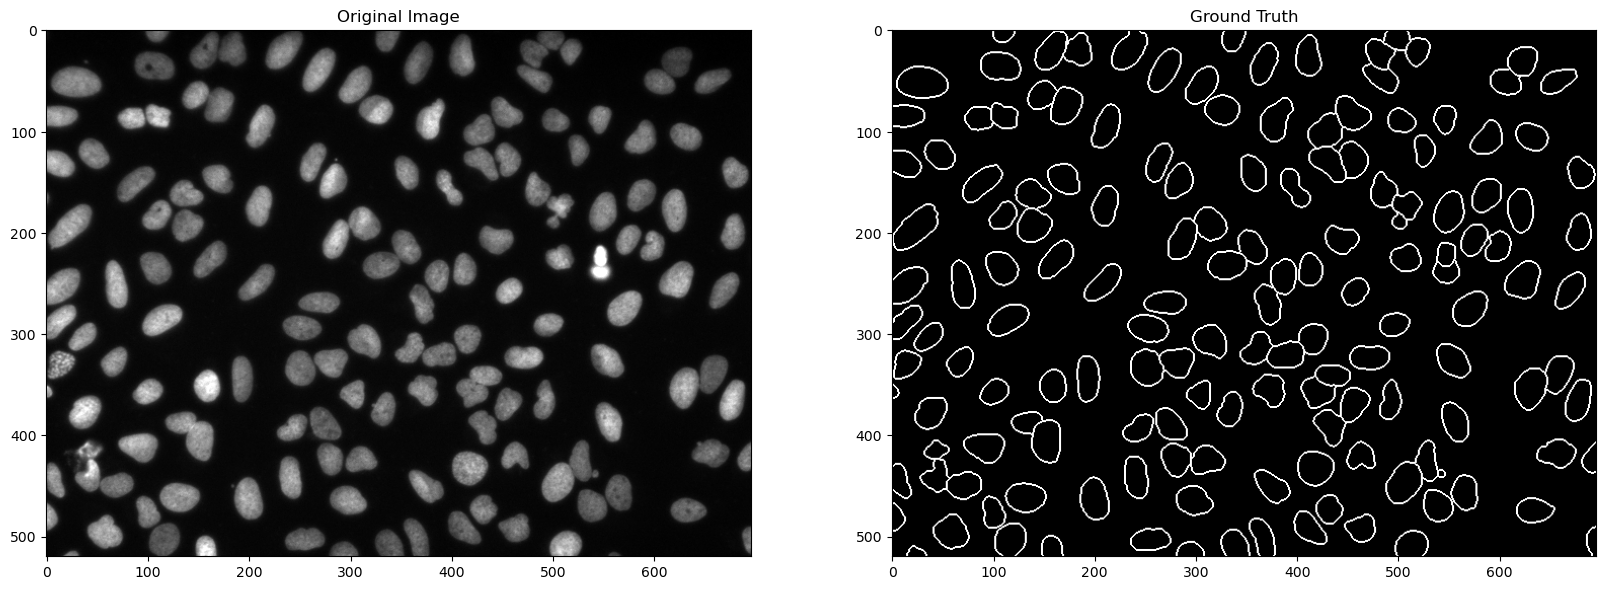

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

rand_int = 0
rand_file_name = test_files[rand_int].strip('\n')
test_img = skimage.io.imread(os.path.join(config['dest_dir'], 'test/images', rand_file_name))
test_annot = skimage.io.imread(os.path.join(config['dest_dir'], 'test/boundary_labels', rand_file_name))

checkpoint = torch.load(
    'checkpoints/binary_contour_1000epochs_ResUNET_AUGMENTED.pth.tar',
    map_location=torch.device(device)
)

model, test_transform = load_model('ResUNET', checkpoint=checkpoint, device=device)
show_prediction(
    test_img,
    test_annot,
    model,
    model_architecture='ResUNET',
    size=10,
    device=device,
    transform=test_transform
)

IXMtest_A12_s7_w1EAEEA614-51ED-43B3-A4FF-088730911E4C.png
(520, 696)


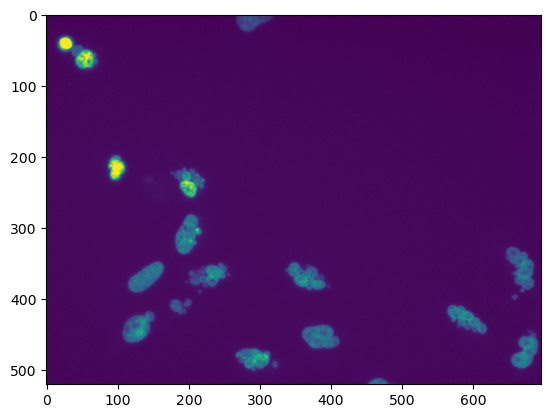

(520, 696, 3)


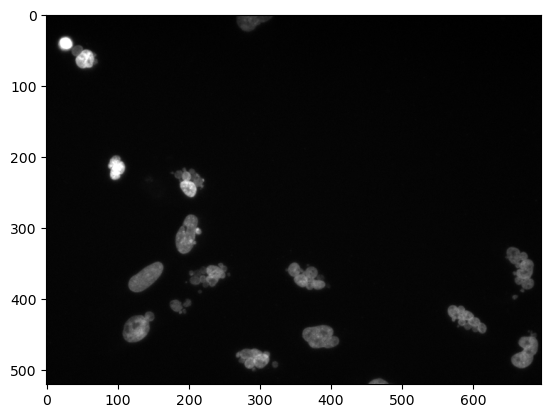

In [47]:
rand_file_name = test_files[1].strip('\n')
print(rand_file_name)
img = skimage.io.imread(os.path.join(config['dest_dir'], 'test/images', rand_file_name))

# Create a 3-channel image where each channel contains the grayscale matrix
rgb_image = np.repeat(img[:, :, np.newaxis], 3, axis=2)

print(img.shape)
plt.imshow(img)
plt.show()

print(rgb_image.shape)
plt.imshow(rgb_image)
plt.show()

assert np.array_equal(img, rgb_image[:, :, 0])
assert np.array_equal(img, rgb_image[:, :, 1])
assert np.array_equal(img, rgb_image[:, :, 2])